In [9]:
import os
from typing import Dict
import requests
from tavily import TavilyClient
from langchain_core.tools import tool

from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage,
    ToolMessage
)

from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

from dotenv import load_dotenv


In [10]:
load_dotenv()

True

In [11]:
@tool
def random_got_quote_tool()->Dict:
    """Randomly select a quote from the Game of Thrones series"""
    response = requests.get("https://api.gameofthronesquotes.xyz/v1/random")
    return response.json()


In [14]:
random_got_quote_tool.invoke({})

{'sentence': "Your lips are moving and you're complaining about something. That's whinging. This one's been killed six times. (points to Beric) You don't hear him bitching about it.",
 'character': {'name': 'Sandor Clegane',
  'slug': 'sandor',
  'house': {'name': "House Clegane of Clegane's Keep", 'slug': 'clegane'}}}

In [15]:
tavily_client = TavilyClient(
    api_key=os.getenv("TAVILY_API_KEY")
)

MissingAPIKeyError: API key is required. Set TAVILY_API_KEY environment variable or pass api_key parameter

In [17]:
@tool
def web_search(question:str)->Dict:
    """Return top search results for the question"""
    response = tavily_client.search(question)
    return response.json()

In [18]:
web_search.invoke("Who performs Cersei Lannister in Game of Thrones?")

NameError: name 'tavily_client' is not defined

In [21]:
tools=[random_got_quote_tool, web_search]

In [22]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

In [23]:
llm_with_tools=llm.bind_tools(tools)

In [24]:
def agent(state:MessagesState):
    ai_message = llm_with_tools.invoke(state.messages)
    return {"messages": [ai_message]}

In [26]:
def router(state: MessagesState):
    last_message = state.messages[-1]
    if last_message.type == "tool":
        return "tool"
    return END


In [28]:
workflow = StateGraph(MessagesState)
workflow.add_node("agents", agent)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "agents")
workflow.add_conditional_edges(
    source="agents",
    path=router,
    path_map=["tools", END]
)
workflow.add_edge("tools", "agents")

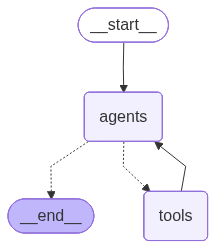

In [29]:
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
messages = [
    SystemMessage(
        "You are a Web Researcher focused on Game of Thrones. "
        "If user asks you a random quote about GoT. You will not only " 
        "provide it, but also search the web to find the actor or actress "
        "who perform the character who said that."
        "So, your output should be: Quote, Character and Performer."
    ),
    HumanMessage("Give me a radom GoT quote")
]

In [32]:
result = graph.invoke(
    input={
        "messages": messages
    }
)
print(result)

AttributeError: 'dict' object has no attribute 'messages'

In [ ]:
for message in result["messages"]:
    message.pretty_print()